In [1]:
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt

In [2]:
pd.set_option(
    'display.max_rows', 100
)
url ="http://publicplansdata.org/api/"
focus_plans_list=['101', '110', '125', '179']
most_improved_list=['124', '90', '89', '134', '123']
least_improved_list=['41', '122', '120', '40', '119']
hardest_hit_list=['168', '130', '184', '151', '31']

In [3]:
study_plans_dict={"steady plans":focus_plans_list,
                        "most improved plans":most_improved_list,
                        "least improved plans":least_improved_list,
                        "hardest hit plans":hardest_hit_list}

In [4]:
paramsratios = {
    "q": "QDataset",
    "dataset": "pensiongasbschedules",
     "format": "json"
}
paramsbasicplandata = {
    "q": "QDataset",
    "dataset": "pensionplanbasics",
     "format": "json"
}
paramspenincomestatement = {
    "q": "QDataset",
    "dataset": "pensionincomestatement",
     "format": "json",
    #"variables": 
     #"v": ,
}

In [5]:
#create requests
ratiosresponse = requests.get(url, params = paramsratios)
plandataresponse = requests.get(url,params=paramsbasicplandata)
penincomestatementresponse = requests.get(url,params=paramspenincomestatement)

In [6]:
#create json response object
fundedratiosdata = ratiosresponse.json()
plandata = plandataresponse.json()
penincomestatement = penincomestatementresponse.json()

In [7]:
#change response object into DataFrame
funded_ratios_full = pd.DataFrame(fundedratiosdata[1:])
plan_data_full = pd.DataFrame(plandata[1:])
penincomestatement_data_full = pd.DataFrame(penincomestatement[1:])

In [8]:
plan_data_df=plan_data_full[['ppd_id','PlanName','StateAbbrev','PlanClosed','PlanYearClosed',]]
penincomestatement_data_full.columns

Index(['adjustment_MktAssets', 'BegMktAssets_net', 'contrib_EE_other',
       'contrib_EE_PurchaseService', 'contrib_EE_regular', 'contrib_ER_other',
       'contrib_ER_regular', 'contrib_ER_state', 'contrib_ER_tot',
       'contrib_other', 'contrib_other_tot', 'contrib_tot', 'EEGroupID',
       'expense_AdminExpenses', 'expense_alternatives', 'expense_COLABenefits',
       'expense_DeathBenefits', 'expense_Depreciation',
       'expense_DisabilityBenefits', 'expense_DROPBenefits',
       'expense_investments', 'expense_investments_tot',
       'expense_LumpSumBenefits', 'expense_net', 'expense_OtherBenefits',
       'expense_OtherDeductions', 'expense_OtherInvestments',
       'expense_other_tot', 'expense_PrivateEquity', 'expense_RealEstate',
       'expense_refunds', 'expense_RetBenefits', 'expense_SecLendMgmtFees',
       'expense_SecuritiesLending', 'expense_SurvivorBenefits',
       'expense_TotBenefits', 'FairValueChange_investments',
       'FairValueChange_RealEstate', 'FairVa

In [9]:
#Create DF and drop any rows with empty data
penincomestatement_data_df=penincomestatement_data_full[['ppd_id','fy','expense_AdminExpenses','expense_investments_tot','MktAssets_net','BegMktAssets_net']].dropna()
funded_ratio_df=funded_ratios_full[['ppd_id','fy','ActFundedRatio_GASB','ActFundedRatio_est','PercentReqContPaid']].dropna()

In [10]:
penincomestatement_data_df.shape

(3570, 6)

In [11]:
plan_income_data_df=pd.merge(penincomestatement_data_df,plan_data_df,how="inner",on="ppd_id")
plan_income_data_df['expense_AdminExpenses'] = plan_income_data_df['expense_AdminExpenses'].astype(float)
plan_income_data_df['expense_investments_tot'] = plan_income_data_df['expense_investments_tot'].astype(float)

In [12]:
plan_income_data_df.shape

(3570, 10)

In [13]:
focus_plans_income_data_df=plan_income_data_df[plan_income_data_df["ppd_id"].isin(focus_plans_list)]
focus_plans_income_data_df

,ppd_id,fy,expense_AdminExpenses,expense_investments_tot,MktAssets_net,BegMktAssets_net,PlanName,StateAbbrev,PlanClosed,PlanYearClosed
1919,101,2001,-2403.024,-9826.902,4939706.000,5156295.000,South Dakota RS,SD,0,None
1920,101,2002,-2440.353,-11363.016,4624900.000,4939706.000,South Dakota RS,SD,0,None
1921,101,2003,-2796.941,-12750.676,4784187.000,4624900.000,South Dakota RS,SD,0,None
1922,101,2004,-2493.039,-9100.952,5518226.000,4784187.000,South Dakota RS,SD,0,None
1923,101,2005,-2772.121,-11099.486,6159935.000,5518226.000,South Dakota RS,SD,0,None
1924,101,2006,-2697.571,-14720.762,6844629.500,6159935.000,South Dakota RS,SD,0,None
1925,101,2007,-3033.519,-20406.455,8158168.500,6844629.500,South Dakota RS,SD,0,None
1926,101,2008,-3352.380,-30735.193,7312107.500,8158168.500,South Dakota RS,SD,0,None
1927,101,2009,-3428.853,-40948.699,5648767.000,7312107.500,South Dakota RS,SD,0,None
1928,101,2010,-3402.075,-39638.070,6496635.000,5648767.000,South Dakota RS,SD,0,None


In [14]:
plan_income_funded_data_df=pd.merge(plan_income_data_df,funded_ratio_df,how="inner",left_on=["ppd_id","fy"],right_on=["ppd_id","fy"])

In [15]:
plan_income_funded_data_df.head(5)

,ppd_id,fy,expense_AdminExpenses,expense_investments_tot,MktAssets_net,BegMktAssets_net,PlanName,StateAbbrev,PlanClosed,PlanYearClosed,ActFundedRatio_GASB,ActFundedRatio_est,PercentReqContPaid
0,1,2001,-4578.0,-1593.0,7236735.000,7918585.000,Alabama ERS,AL,0,None,1.00200,0.000,1.00000
1,1,2002,-5582.0,-2331.0,6424435.000,7236735.000,Alabama ERS,AL,0,None,0.95400,0.000,1.00000
2,1,2003,-5843.0,-2380.0,7222812.000,6424435.000,Alabama ERS,AL,0,None,0.91100,0.000,1.00000
3,1,2004,-5892.0,-2390.0,7795598.000,7222812.000,Alabama ERS,AL,0,None,0.89700,0.000,1.00000
4,1,2005,-6898.0,-2652.0,8464515.000,7795598.000,Alabama ERS,AL,0,None,0.84000,0.000,1.00000


In [16]:
plan_income_funded_data_df['ActFundedRatio_GASB'] = plan_income_funded_data_df['ActFundedRatio_GASB'].astype(float)
plan_income_funded_data_df['PercentReqContPaid'] = plan_income_funded_data_df['PercentReqContPaid'].astype(float)
plan_income_funded_data_df['MktAssets_net'] = plan_income_funded_data_df['MktAssets_net'].astype(float)
plan_income_funded_data_df['BegMktAssets_net'] = plan_income_funded_data_df['BegMktAssets_net'].astype(float)

In [17]:
plan_income_funded_data_df['Avg_Assets']=(plan_income_funded_data_df['MktAssets_net']+plan_income_funded_data_df['BegMktAssets_net'])/2
plan_income_funded_data_df['Total_absExpenses']=plan_income_funded_data_df['expense_AdminExpenses'].abs()+plan_income_funded_data_df['expense_investments_tot'].abs()
plan_income_funded_data_df

,ppd_id,fy,expense_AdminExpenses,expense_investments_tot,MktAssets_net,BegMktAssets_net,PlanName,StateAbbrev,PlanClosed,PlanYearClosed,ActFundedRatio_GASB,ActFundedRatio_est,PercentReqContPaid,Avg_Assets,Total_absExpenses
0,1,2001,-4578.000,-1593.000,7236735.00,7918585.0,Alabama ERS,AL,0,None,1.002,0.000,1.00000,7577660.000,6171.000
1,1,2002,-5582.000,-2331.000,6424435.00,7236735.0,Alabama ERS,AL,0,None,0.954,0.000,1.00000,6830585.000,7913.000
2,1,2003,-5843.000,-2380.000,7222812.00,6424435.0,Alabama ERS,AL,0,None,0.911,0.000,1.00000,6823623.500,8223.000
3,1,2004,-5892.000,-2390.000,7795598.00,7222812.0,Alabama ERS,AL,0,None,0.897,0.000,1.00000,7509205.000,8282.000
4,1,2005,-6898.000,-2652.000,8464515.00,7795598.0,Alabama ERS,AL,0,None,0.840,0.000,1.00000,8130056.500,9550.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3411,204,2016,-6338.669,-7537.844,2400023.25,2456543.5,Houston Municipal,TX,0,None,0.555,0.000,0.98600,2428283.375,13876.513
3412,204,2017,-6021.146,-7391.470,2602664.75,2400023.3,Houston Municipal,TX,0,None,0.564,0.000,0.98823,2501344.025,13412.616
3413,204,2018,-5786.175,-7667.752,2988864.25,2598058.3,Houston Municipal,TX,0,None,0.577,0.000,0.99427,2793461.275,13453.927
3414,204,2019,-4699.295,-8018.947,3100999.00,2988864.3,Houston Municipal,TX,0,None,0.593,0.000,0.98881,3044931.650,12718.242


In [18]:
plan_income_funded_data_df['Exp_Asset_Ratio']=plan_income_funded_data_df['Total_absExpenses']/plan_income_funded_data_df['Avg_Assets']
plan_income_funded_data_df['Exp_Asset_Ratio'].describe()

count    3416.000000
mean        0.004877
std         0.002948
min         0.000003
25%         0.002889
50%         0.004384
75%         0.006293
max         0.027690
Name: Exp_Asset_Ratio, dtype: float64

steady plans
steady plans


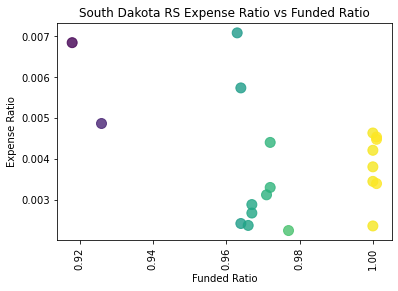

steady plans


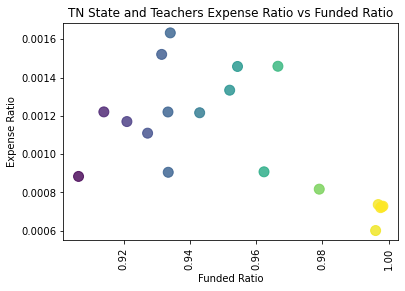

steady plans


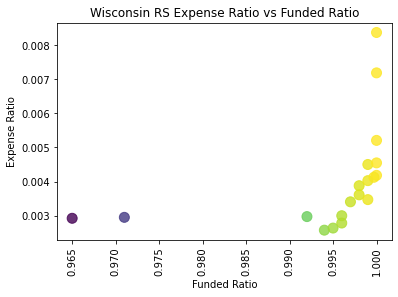

steady plans


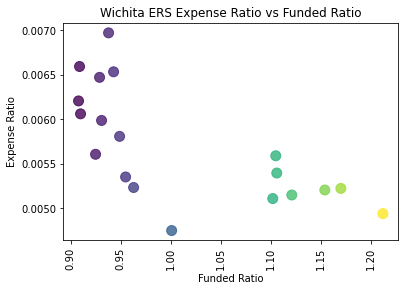

most improved plans
most improved plans


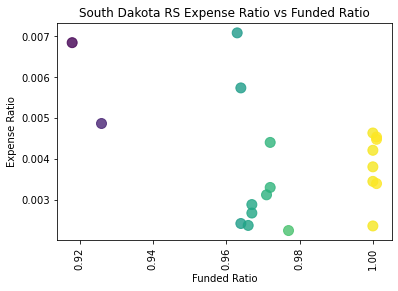

most improved plans


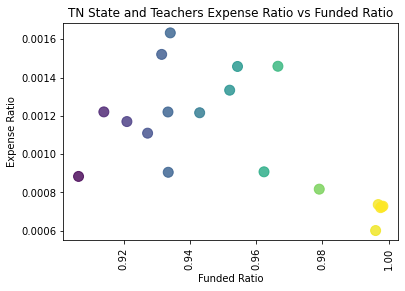

most improved plans


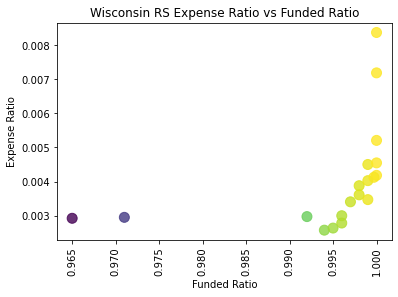

most improved plans


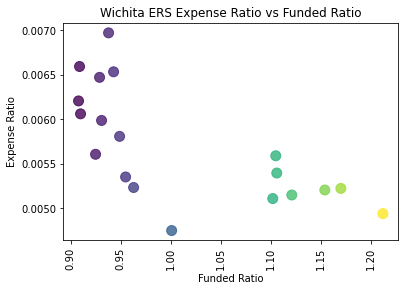

least improved plans
least improved plans


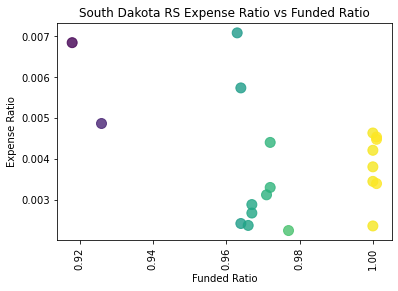

least improved plans


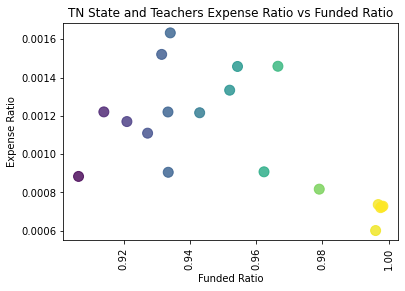

least improved plans


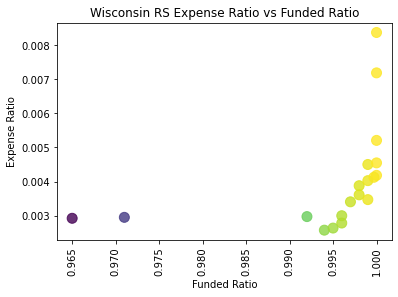

least improved plans


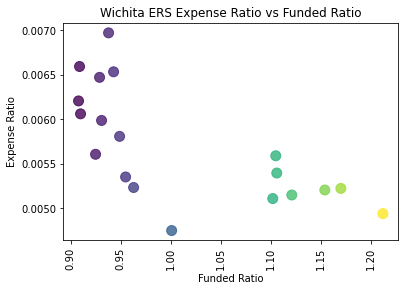

hardest hit plans
hardest hit plans


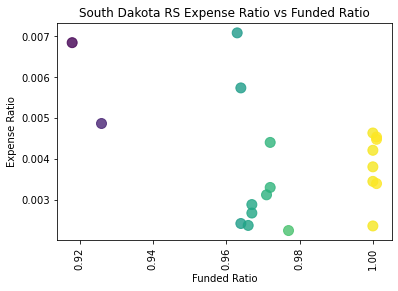

hardest hit plans


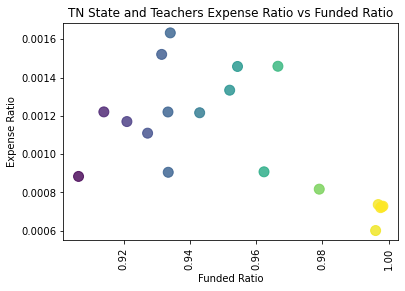

hardest hit plans


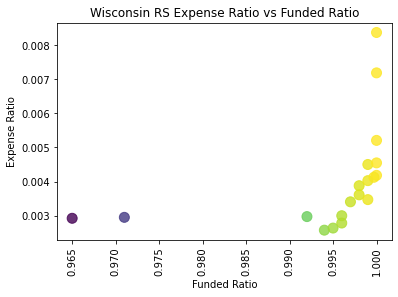

hardest hit plans


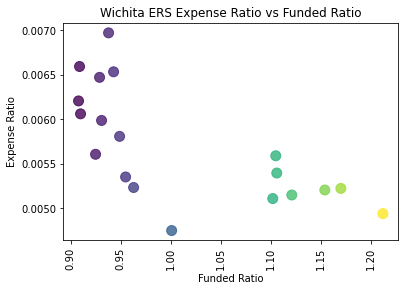

steady plans
steady plans


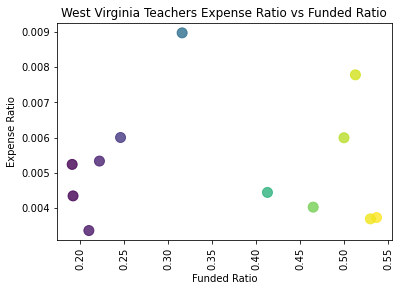

steady plans


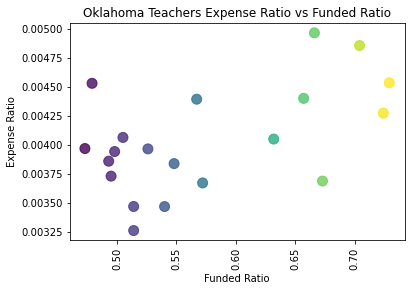

steady plans


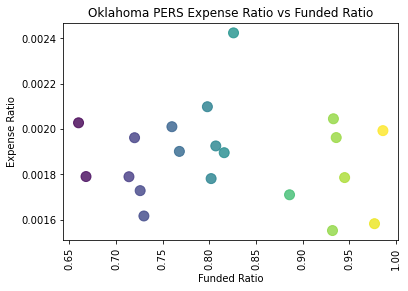

steady plans


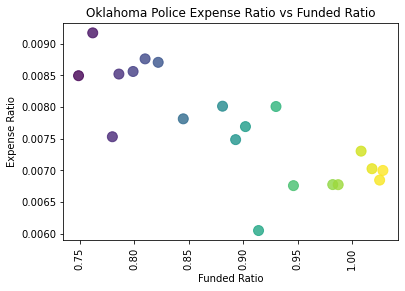

steady plans


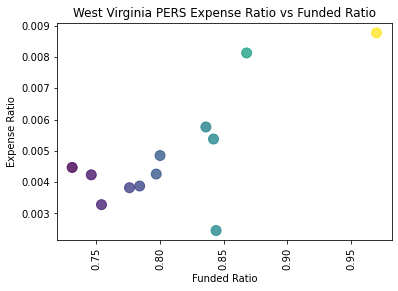

most improved plans
most improved plans


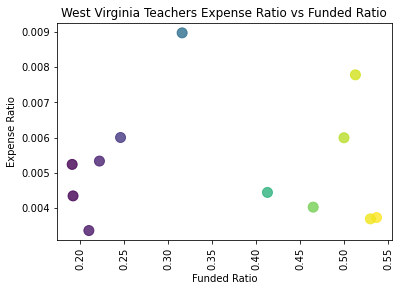

most improved plans


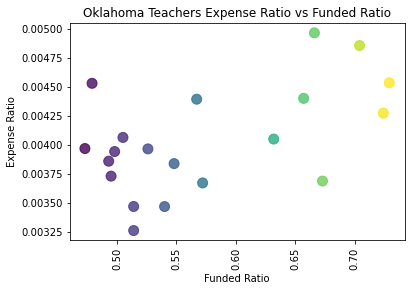

most improved plans


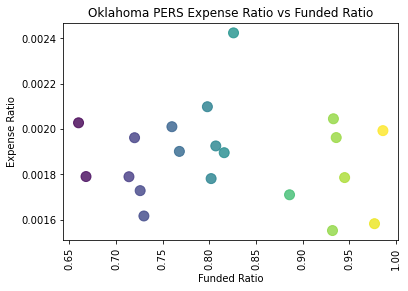

most improved plans


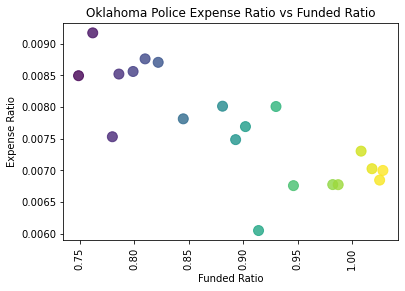

most improved plans


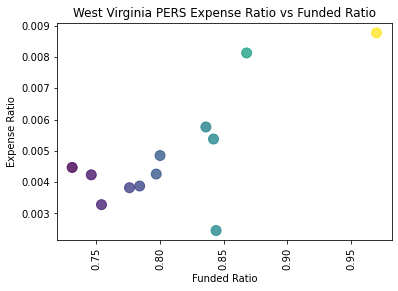

least improved plans
least improved plans


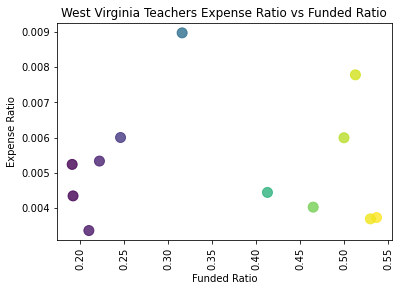

least improved plans


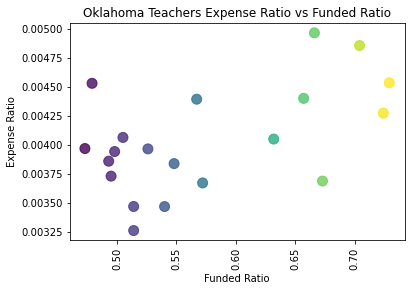

least improved plans


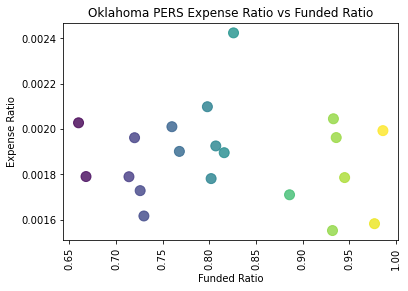

least improved plans


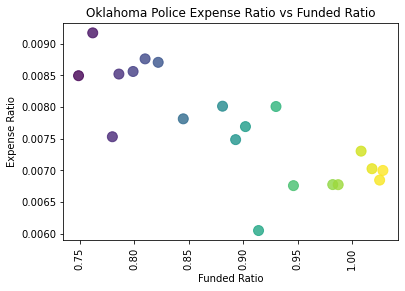

least improved plans


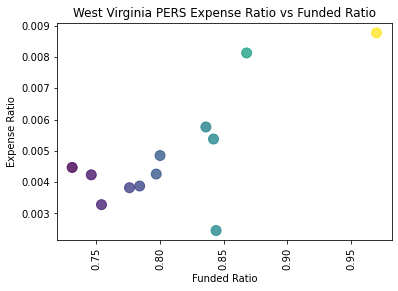

hardest hit plans
hardest hit plans


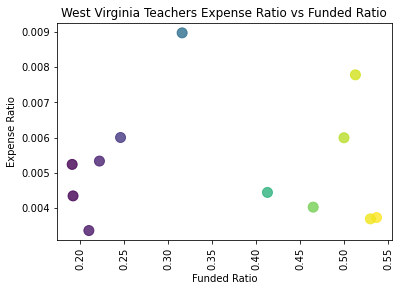

hardest hit plans


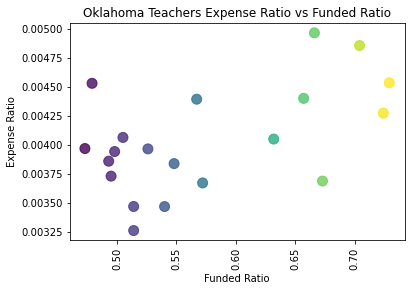

hardest hit plans


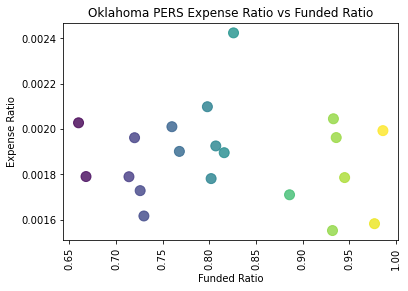

hardest hit plans


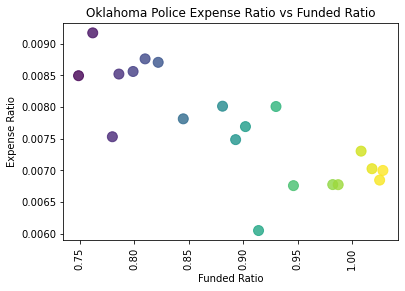

hardest hit plans


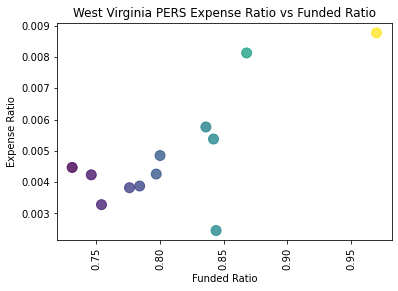

steady plans
steady plans


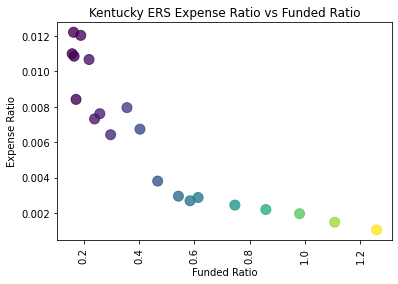

steady plans


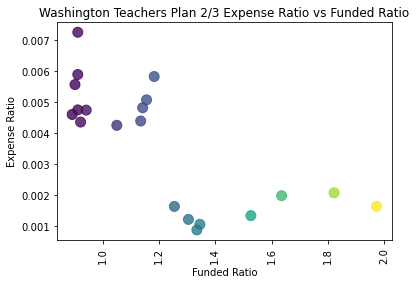

steady plans


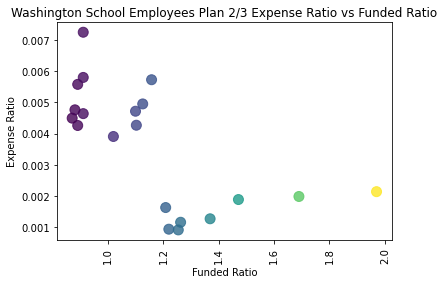

steady plans


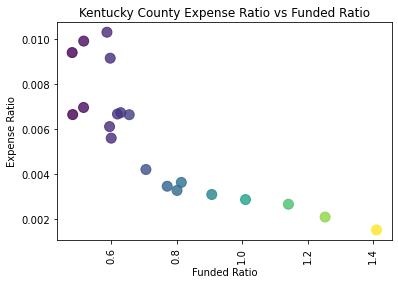

steady plans


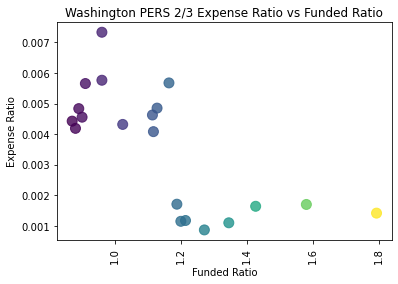

most improved plans
most improved plans


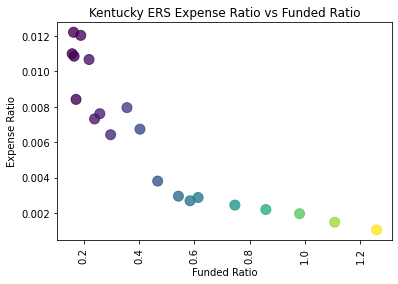

most improved plans


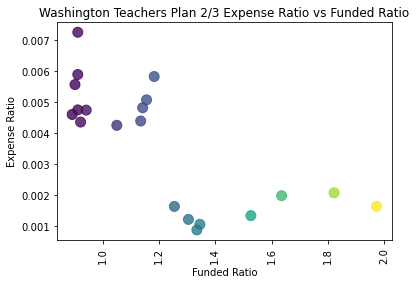

most improved plans


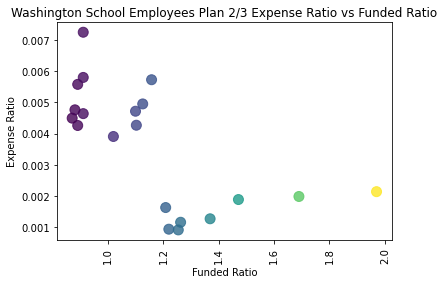

most improved plans


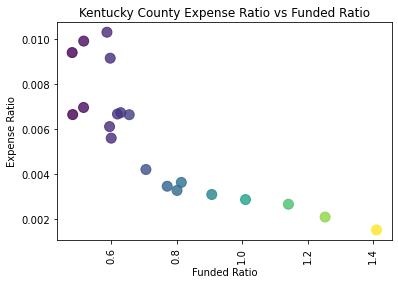

most improved plans


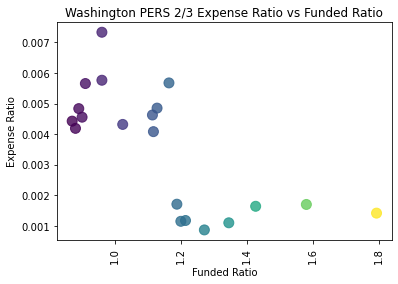

least improved plans
least improved plans


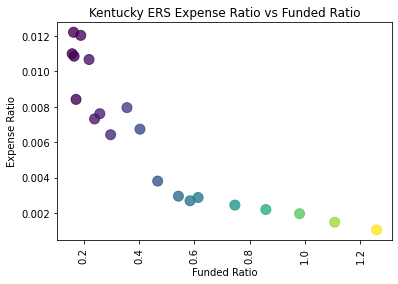

least improved plans


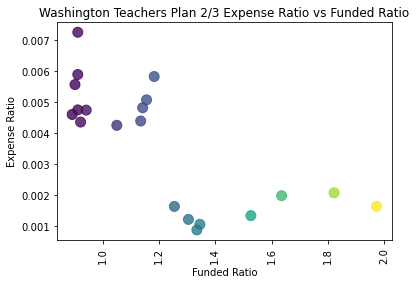

least improved plans


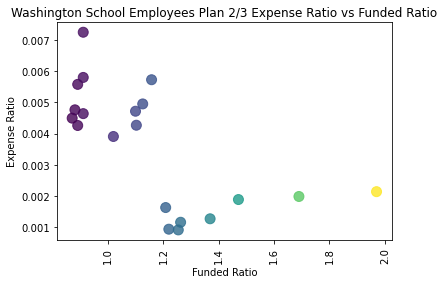

least improved plans


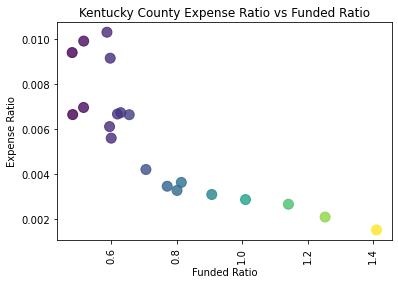

least improved plans


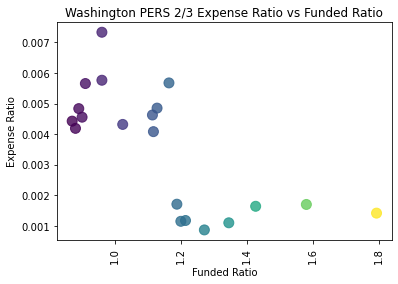

hardest hit plans
hardest hit plans


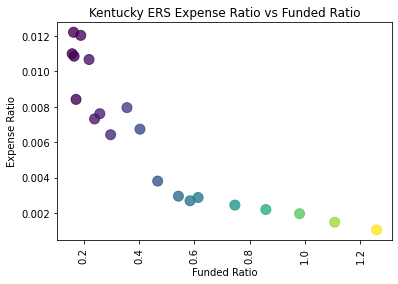

hardest hit plans


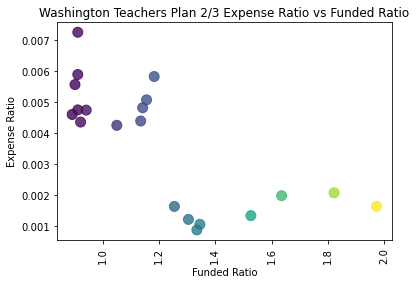

hardest hit plans


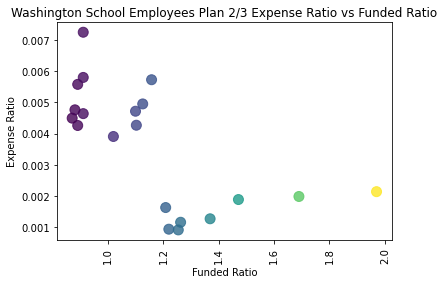

hardest hit plans


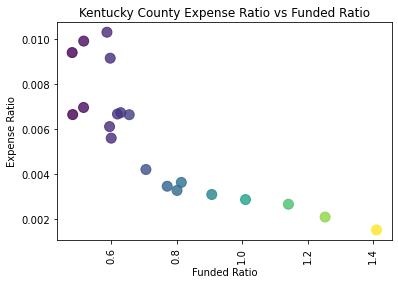

hardest hit plans


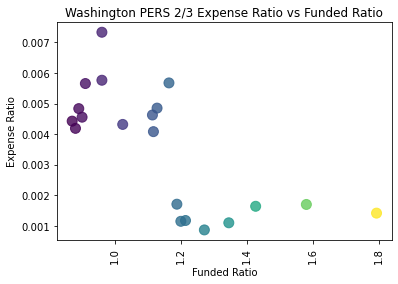

steady plans
steady plans


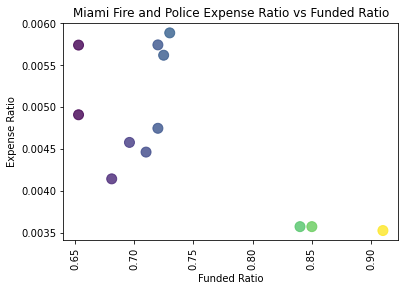

steady plans


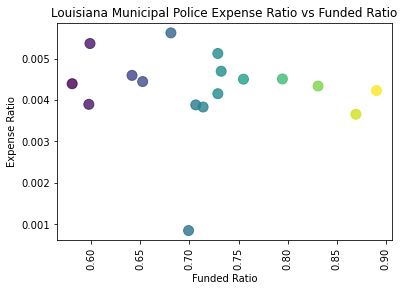

steady plans


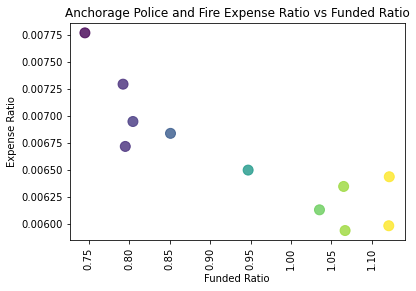

steady plans


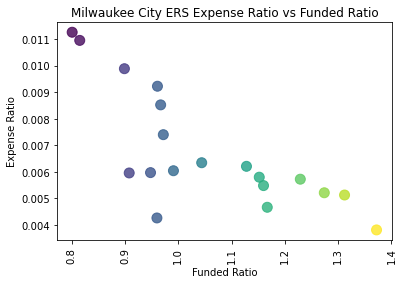

steady plans


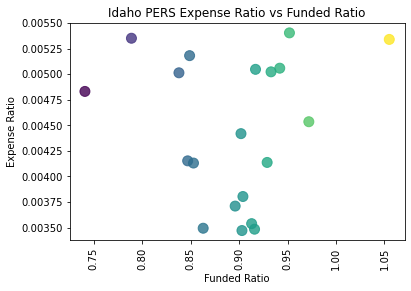

most improved plans
most improved plans


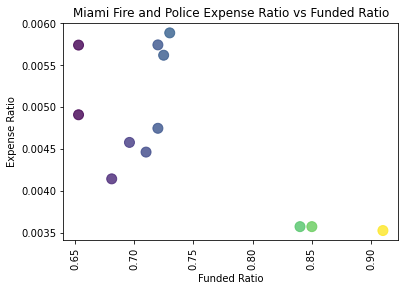

most improved plans


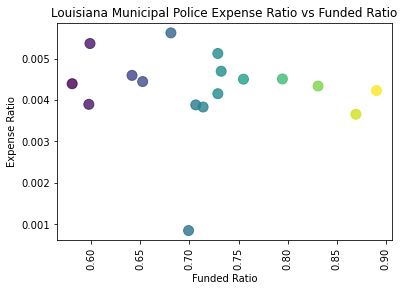

most improved plans


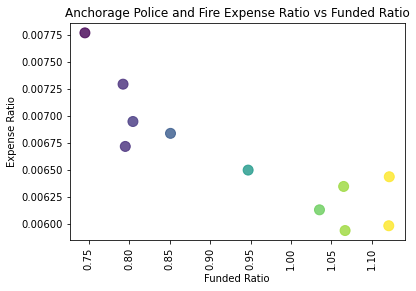

most improved plans


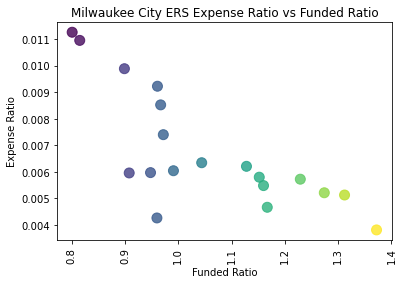

most improved plans


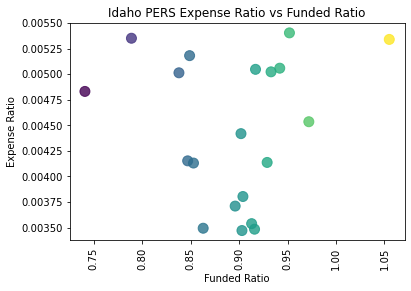

least improved plans
least improved plans


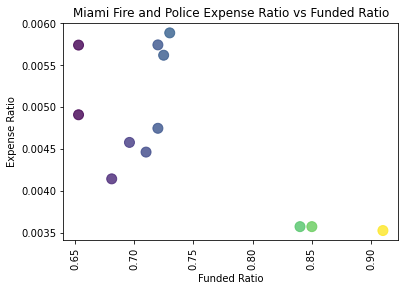

least improved plans


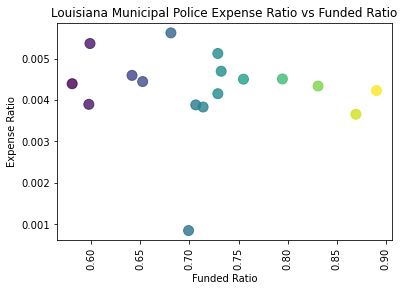

least improved plans


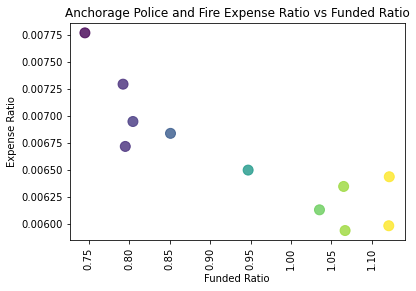

least improved plans


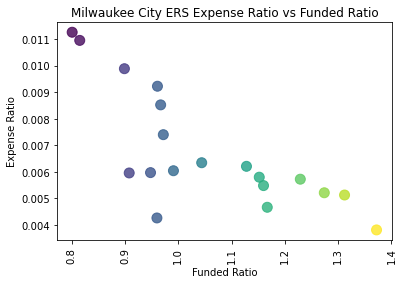

least improved plans


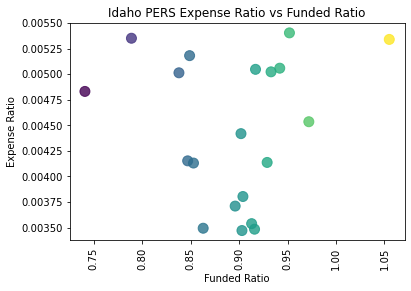

hardest hit plans
hardest hit plans


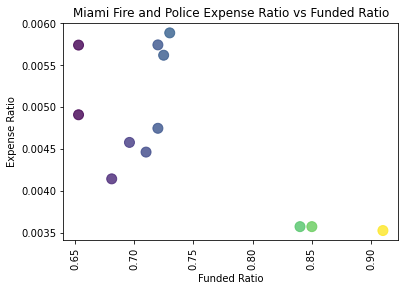

hardest hit plans


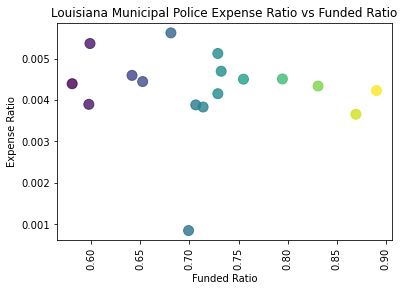

hardest hit plans


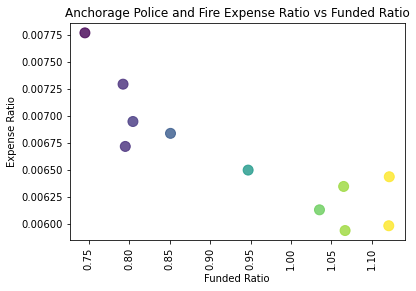

hardest hit plans


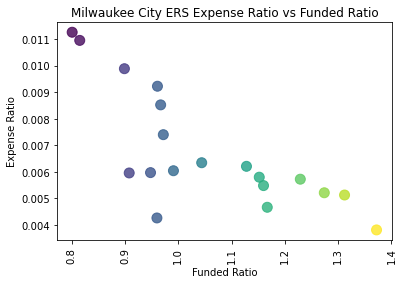

hardest hit plans


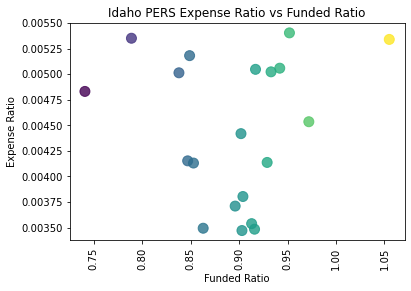

In [21]:
for key,value in study_plans_dict.values():
    for plans in value:
        plan_x=plan_income_funded_data_df[plan_income_funded_data_df["ppd_id"]==plans]
        plan_x_exprat=plan_x["Exp_Asset_Ratio"]
        plan_x_fundrat=plan_x["ActFundedRatio_GASB"]
        plan_x_fy=plan_x["fy"]
            plan_x_name=plan_data_df.loc[plan_data_df['ppd_id'] == plans, 'PlanName'].iloc[0]
            print(key)
        plt.title(f'{plan_x_name} Expense Ratio vs Funded Ratio')
        plt.xlabel("Funded Ratio")
        plt.ylabel("Expense Ratio")
        plt.scatter(plan_x_fundrat,plan_x_exprat,c=plan_x_fundrat,s=100,alpha=.8)
        plt.xticks(rotation=90)
        plt.show()

In [ ]:
for plans in most_improved_list:
    plan_x=plan_income_funded_data_df[plan_income_funded_data_df["ppd_id"]==plans]
    plan_x_exprat=plan_x["Exp_Asset_Ratio"]
    plan_x_fundrat=plan_x["ActFundedRatio_GASB"]
    plan_x_fy=plan_x["fy"]
    plan_x_name=plan_data_df.loc[plan_data_df['ppd_id'] == plans, 'PlanName'].iloc[0]
    plt.title(f'{plan_x_name} Expense Ratio vs Funded Ratio')
    plt.xlabel("Funded Ratio")
    plt.ylabel("Expense Ratio")
    plt.scatter(plan_x_fundrat,plan_x_exprat,c=plan_x_fundrat,s=100,alpha=.8)
    plt.xticks(rotation=90)
    plt.show

In [ ]:
for plans in least_improved_list:
    plan_x=plan_income_funded_data_df[plan_income_funded_data_df["ppd_id"]==plans]
    plan_x_exprat=plan_x["Exp_Asset_Ratio"]
    plan_x_fundrat=plan_x["ActFundedRatio_GASB"]
    plan_x_fy=plan_x["fy"]
    plan_x_name=plan_data_df.loc[plan_data_df['ppd_id'] == plans, 'PlanName'].iloc[0]
    plt.title(f'{plan_x_name} Expense Ratio vs Funded Ratio')
    plt.xlabel("Funded Ratio")
    plt.ylabel("Expense Ratio")
    plt.scatter(plan_x_fundrat,plan_x_exprat,c=plan_x_fundrat,s=100,alpha=.8)
    plt.xticks(rotation=90)
    plt.show

In [ ]:
for plans in hardest_hit_list:
    plan_x=plan_income_funded_data_df[plan_income_funded_data_df["ppd_id"]==plans]
    plan_x_exprat=plan_x["Exp_Asset_Ratio"]
    plan_x_fundrat=plan_x["ActFundedRatio_GASB"]
    plan_x_fy=plan_x["fy"]
    plan_x_name=plan_data_df.loc[plan_data_df['ppd_id'] == plans, 'PlanName'].iloc[0]
    plt.title(f'{plan_x_name} Expense Ratio vs Funded Ratio')
    plt.xlabel("Funded Ratio")
    plt.ylabel("Expense Ratio")
    plt.scatter(plan_x_fundrat,plan_x_exprat,c=plan_x_fundrat,s=100,alpha=.8)
    plt.xticks(rotation=90)
    plt.show